### Youtube Transscript generation 

In [1]:
import os 
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
from langchain_groq import ChatGroq

llm = ChatGroq(model="qwen-2.5-32b")

llm.invoke("hello")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003782451, 'queue_time': 0.453042607, 'total_time': 0.053782451}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None}, id='run-14a76a2b-46ae-493f-bab9-8ea7fc78106c-0', usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40})

In [2]:
from youtube_transcript_api import YouTubeTranscriptApi

def get_youtube_transcript(video_id):
    """
    Retrieves the transcript of a YouTube video.

    Args:
        video_id (str): The ID of the YouTube video.

    Returns:
        str: The transcript of the video, or None if an error occurs.
    """
    try:
        transcript_list = YouTubeTranscriptApi.get_transcript(video_id)
        transcript = " ".join([item['text'] for item in transcript_list])
        return transcript
    except YouTubeTranscriptApi.VideoUnavailable:
        return "Video unavailable or transcripts are disabled."
    except YouTubeTranscriptApi.NoTranscriptFound:
        return "No transcript found for this video."
    except Exception as e:
        return f"An error occurred: {e}"

def extract_video_id(youtube_url):
    """
    Extracts the video ID from a YouTube URL.

    Args:
        youtube_url (str): The YouTube URL.

    Returns:
        str: The video ID, or None if it cannot be extracted.
    """
    import re

    video_id_match = re.search(r"(?<=v=)[^&\s]+", youtube_url)
    if video_id_match:
        return video_id_match.group(0)

    video_id_match = re.search(r"(?<=be/)[^&\s]+", youtube_url)
    if video_id_match:
        return video_id_match.group(0)

    return None

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import display,Image

class State(TypedDict):
    video_url: str
    transcript: str
    blog: str
    review: str
    human_feedback: str

In [4]:
def transcript_generation(state: State) -> State:
    # Fetch transcript
    Video_id = extract_video_id(state["video_url"])
    state["transcript"] = get_youtube_transcript(Video_id)
    return state

In [5]:
def blog_generation(state: State) -> State:
    if state.get("human_feedback"):
        state["blog"] = llm.invoke(
            f"Generate a blog post for the transcript below:\n{state['transcript']}\n"
            f"Consider the following feedback: {state['human_feedback']}"
        )
    else:
        state["blog"] = llm.invoke(
            f"Generate a blog post for the transcript below:\n{state['transcript']}"
        )
    return state

In [6]:
def review_generation(state: State) -> State:
    # Generate review
    state["review"] = llm.invoke(f"Generate a review for the blog post below:\n{state['blog']}")
    return state

In [7]:
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command
def human_feedback1(state: State) -> State:
    feedback = interrupt("Please provide your feedback:")
    return {"human_feedback": feedback}

def should_continue(state: State) -> str:
    if state.get("human_feedback"):
        return "blogger"
    return END

In [12]:
builder = StateGraph(State)
# Nodes
builder.add_node("transcriptor", transcript_generation)
builder.add_node("blogger", blog_generation)
builder.add_node("reviewer", review_generation)
builder.add_node("human_analyst_feedback", human_feedback1)
# Edges
builder.add_edge(START, "transcriptor")
builder.add_edge("transcriptor", "blogger")
builder.add_edge("blogger", "reviewer")
builder.add_edge("reviewer", "human_analyst_feedback")
builder.add_conditional_edges("human_analyst_feedback", should_continue, ["blogger", END])

# Compile the workflow with an interrupt before 'human_analyst_feedback'
workflow = builder.compile(interrupt_before=["human_analyst_feedback"])

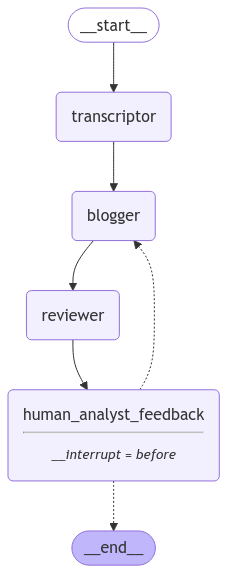

In [13]:
display(Image(workflow.get_graph().draw_mermaid_png()))

In [14]:
res = workflow.invoke({"video_url":"https://www.youtube.com/watch?v=LKFuXETZUsI"})

In [15]:
res

{'video_url': 'https://www.youtube.com/watch?v=LKFuXETZUsI',
 'transcript': "[Music] for Generations this peaceful island has been home to our families but beyond our Reef a great danger is coming Legend tells of a hero who will journey to find the demigod Maui and together they will save us all Lou [Applause] [Music] a boat Maui shap shifter demigod of the Wind and Sea I am hero of men what it's actually Maui Shape Shifter demigod of the Wind and Sea hero of men I interrupted from the top hero of men go I'm not going on a mission with some little girl this is my canoe and you will journey to different did not see that coming the ocean is a friend of mine first we've got to go through a whole ocean of bad kakamura coak what they're kind of cute [Applause] [Music] he got your back it's Maui time really blow dart in my butt cheek we're going to the realm of monsters don't worry it's a lot farther down than it looks I am still falling",
 'blog': AIMessage(content='### A Hero\'s Journey: T